# ICPR 2024 Competition on Multilingual Claim-Span Identification

## Installing Dependencies

In [ ]:
#!pip install transformers

### Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer
from tokenizers import BertWordPieceTokenizer
from keras.layers import Input, Dense, Layer
from keras.models import Model
from keras.optimizers import Adam

### Loading Datasets

In [ ]:
# Training English and Hindi datasets
train_data = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/ML Data/train_en_hi_encoded_labels.json")


# Validation English and Hindi datasets
val_data = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/ML Data/val_en_hi_encoded_labels.json")

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12068 entries, 0 to 12067
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claims       12068 non-null  int64 
 1   text_tokens  12068 non-null  object
 2   labels       12068 non-null  object
dtypes: int64(1), object(2)
memory usage: 283.0+ KB


In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claims       999 non-null    int64 
 1   text_tokens  999 non-null    object
 2   labels       999 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB


In [ ]:
X_val = val_data["text_tokens"]
y_val = val_data["claims"]

In [ ]:
# Configuration
EPOCHS = 2
BATCH_SIZE = 16
MAX_LEN = 192

# Load the real tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)

    all_ids = []

    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i + chunk_size].tolist()
        encodings = tokenizer.encode_batch(text_chunk)
        all_ids.extend([encoding.ids for encoding in encodings])

    return np.array(all_ids)

In [ ]:
x_train = fast_encode(train_data.text_tokens.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(val_data.text_tokens.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train_data.claims.values
y_valid = val_data.claims.values

In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
class DistilBertLayer(Layer):
    def __init__(self, transformer, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.transformer = transformer

    def call(self, inputs):
        outputs = self.transformer(inputs)
        return outputs.last_hidden_state

def build_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = DistilBertLayer(transformer)(input_word_ids)
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    model = Model(inputs=input_word_ids, outputs=out)
    return model

In [ ]:
# Initialize the TFDistilBertModel
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

# Build the model
model = build_model(transformer_model, MAX_LEN)

# Compile the model with Adam optimizer instance
model.compile(optimizer=Adam(learning_rate=3e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 192)]             0         
 )                                                               
                                                                 
 distil_bert_layer (DistilB  (None, 192, 768)          134734080 
 ertLayer)                                                       
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 134734849 (513.97 MB)
Trainable params: 134734849 (513.97 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [ ]:
# Train the model on the training dataset
train_history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

# Predict on the validation dataset
scores = model.predict(valid_dataset)

Epoch 1/2
755/755 [==============================] - 277s 332ms/step - loss: 0.3931 - accuracy: 0.8276 - val_loss: 0.3842 - val_accuracy: 0.8398
Epoch 2/2
63/63 [==============================] - 10s 106ms/step


In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

def roc_auc(predictions, target):
    '''
    This method returns the AUC Score and plots the ROC Curve when given the Predictions
    and Labels
    '''
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # Plotting the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC Score = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic(ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

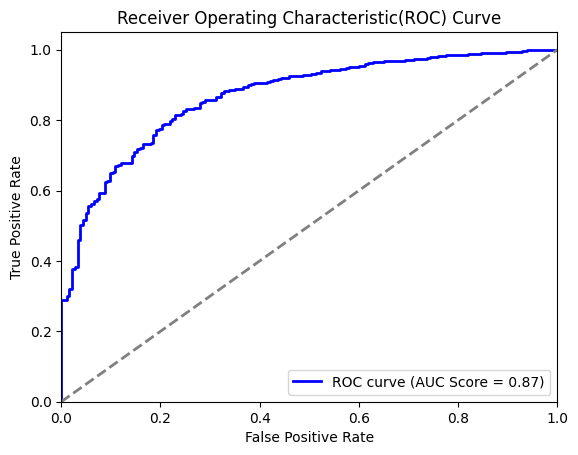

[{'Model': 'Distil-BERT', 'ROC Curve and AUC_Score': 0.8688055823422266}]


In [ ]:
scores_model = []

scores_model.append({'Model': 'Distil-BERT','ROC Curve and AUC_Score': roc_auc(scores, y_val)})

print(scores_model)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

# Step 1: Make predictions on the validation set
predictions = (model.predict(valid_dataset) > 0.5).astype(int)

# Step 2: Calculate Jaccard similarity score
jaccard = jaccard_score(y_val, predictions)

# Step 3: Calculate Macro-F1 score
macro_f1 = f1_score(y_val, predictions, average='macro')

print("Jaccard Similarity Score of Distil-BERT:", jaccard)
print("Macro-F1 Score of Distil-BERT:", macro_f1)

63/63 [==============================] - 7s 104ms/step
Jaccard Similarity Score of Distil-BERT: 0.8068571428571428
Macro-F1 Score of Distil-BERT: 0.7439149249860073


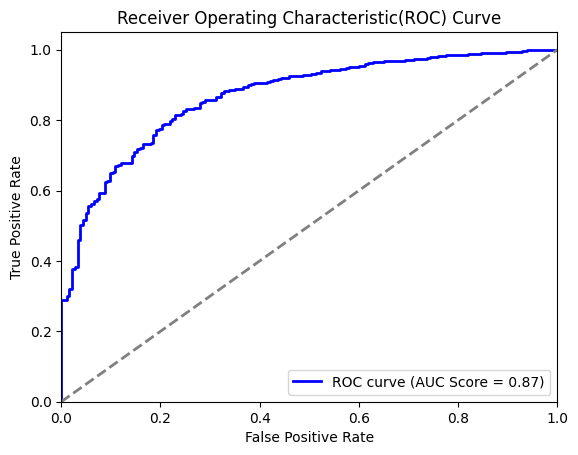

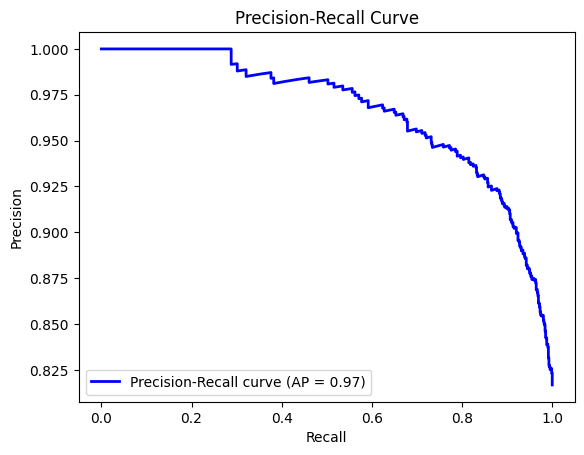

[{'Model': 'Distil-BERT', 'ROC Curve and AUC Score': 0.8688055823422266}, {'Model': 'Distil-BERT', 'Precision-Recall Curve and AP Score': 0.9661146409861183}]


In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

def precision_recall_ap(predictions, target):
    '''
    This method returns the Average Precision (AP) Score and plots the Precision-Recall Curve
    when given the Predictions and Labels.
    '''
    precision, recall, thresholds = metrics.precision_recall_curve(target, predictions)
    average_precision = metrics.average_precision_score(target, predictions)

    # Plotting the Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    return average_precision

# Assuming `scores` and `y_val` are predefined lists containing your predictions and true labels respectively
scores_model = []

# Compute ROC AUC and add to the list
roc_auc_score = roc_auc(scores, y_val)
scores_model.append({'Model': 'Distil-BERT', 'ROC Curve and AUC Score': roc_auc_score})

# Compute Precision-Recall AP and add to the list
average_precision = precision_recall_ap(scores, y_val)
scores_model.append({'Model': 'Distil-BERT', 'Precision-Recall Curve and AP Score': average_precision})

print(scores_model)

In [ ]:
from sklearn.metrics import f1_score, jaccard_score
import numpy as np

# Step 1: Make predictions on the validation set
predictions = (model.predict(valid_dataset) > 0.5).astype(int)

# Initialize lists to hold individual scores
jaccard_scores = []
macro_f1_scores = []

# Iterate over each post
for i in range(len(y_val)):
    # Ensure y_val[i] and predictions[i] are arrays
    y_true_post = np.array(y_val[i]).reshape(1, -1)
    y_pred_post = np.array(predictions[i]).reshape(1, -1)

    # Calculate Jaccard similarity score for each post
    jaccard = jaccard_score(y_true_post[0], y_pred_post[0], zero_division=0)
    jaccard_scores.append(jaccard)

    # Calculate Macro-F1 score for each post
    macro_f1 = f1_score(y_true_post[0], y_pred_post[0], average='macro', zero_division=0)
    macro_f1_scores.append(macro_f1)

# Calculate the average of the scores
average_jaccard = np.mean(jaccard_scores)
average_macro_f1 = np.mean(macro_f1_scores)

print("Average Jaccard Similarity Score of Distil-BERT:", average_jaccard)
print("Average Macro-F1 Score of Distil-BERT:", average_macro_f1)

63/63 [==============================] - 7s 108ms/step
Average Jaccard Similarity Score of Distil-BERT: 0.7067067067067067
Average Macro-F1 Score of Distil-BERT: 0.8308308308308309


The updated code correctly calculates the standard IOU/Jaccard and Macro-F1 scores for each post and then averages these metric values over all the posts. This approach adheres to the criteria provided:

1. **Individual Metric Calculation**: For each post, the Jaccard similarity score and Macro-F1 score are calculated.
2. **Averaging Metrics**: The calculated scores for each post are then averaged to get the final metric values.


### Explanation and Compliance with Criteria:

1. **Predictions**: Predictions are made on the entire validation dataset.
2. **Initialization**: Lists (`jaccard_scores` and `macro_f1_scores`) are initialized to store the metric scores for each post.
3. **Iteration and Individual Metrics Calculation**:
   - **Ensuring Array Format**: Each true label (`y_val[i]`) and prediction (`predictions[i]`) is converted to a numpy array and reshaped to ensure compatibility with `jaccard_score` and `f1_score`.
   - **Jaccard Score**: For each post, the Jaccard similarity score is calculated and appended to the `jaccard_scores` list.
   - **Macro-F1 Score**: For each post, the Macro-F1 score is calculated and appended to the `macro_f1_scores` list.
4. **Averaging**: The average Jaccard similarity score and Macro-F1 score are computed using `np.mean` over their respective lists.
5. **Output**: The average scores are printed.

This process ensures that the metric values are first calculated for each individual post and then averaged, aligning perfectly with the evaluation criteria specified.